<h1 align=center><font size = 5>Human Resources (HR) Modelling Clustering with Python</font></h1>

Yang digunakan data employees dan distribution centers

Goals: Mengetahui tingkat produktivitas employee, berarti harus cari tahu variabel apa saja yg berpengaruh terhadap goals

Outline:
* **Part I**
    * Load & Explore Data
        * Data Understanding
    * Data Analysis
        * Exploratory Data Analysis
        * Data Preparation
* **Part II**
    * Model Development
        * Data Preparation
        * Modelling

##Link Referensi



*   https://www.kaggle.com/code/minnyanlinn/absent-hours-prediction-with-shiny-app
*   https://www.kaggle.com/datasets/HRAnalyticRepository/absenteeism-dataset 


*   https://minnyanlinn.shinyapps.io/AbsentHours/
*   https://www.kaggle.com/code/drakedyban/absenteeism-regression-analysis

*   https://www.kaggle.com/code/dsloet/absenteeism-visual-and-regression







## **0 Libraries**

In [ ]:
from pprint import pprint
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats #keperluan perhitungan statistik
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.decomposition import PCA
from matplotlib import colors
from matplotlib.colors import ListedColormap

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 0.1 Data Dictionary

Pertama, kita perlu mengetahui representasi setiap kolom pada data sebelum melakukan eksplorasi lebih jauh.

**Data Employees**

| column | description |
| ------ | ----------- |
| `Fisrt_Name` | Nama depan pegawai  |
| `Last_Name` | Nama belakang pegawai  |
| `Gender` | Jenis kelamin pegawai   |
| `Age` | Usia pegawai sekarang  |
| `Gender` | Jenis kelamin pegawai   |
| `Absent_Hours` | Lama absen dalam satu tahun (jam) dengan alasan apapun termasuk (cuti, sakit, dll)  |
| `Length_Service` | Lama pegawai bekerja diperusahaan The looker (tahun)   |
| `distribution_centers_id` | Distribution centers id (tabel)  |
| `Entry_Age` | (Fitur/kolom baru)  Usia pegawai saat masuk kerja |



**Data Distribution Centers**

Pertama, kita perlu mengetahui representasi setiap kolom pada data sebelum melakukan eksplorasi lebih jauh.

Data Employees

| column | description |
| ------ | ----------- |
| `id` | Id distribution centers  |
| `name` | Nama Distribution Centers  |
| `Gender` | Jenis kelamin pegawai   |
| `latitude` | Titik koordinat latitude |
| `longitude` | Titik koordinat longitude |


## **1 Data Loading & Exploration**

###1.1 Employees

Dilakukan penambahan fitur pada employees yaitu entry_age. 

Penambahan dilakukan di SQL, dan dibutuhkan untuk handling outlier

Penambahan kolom entry_age = age - length_service

In [ ]:
#Ambil data employees
df_emp = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/employee_addv.csv')
df_dc = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/distribution_centers.csv')

In [ ]:
#Jumlah dari data
print("num of employees:", df_emp.shape)
print("num of distribution centers:", df_dc.shape)

num of employees: (8336, 8)
num of distribution centers: (10, 4)


> **Insights:**

Dari angka di atas, terdapat total pegawai sebanyak **8336** tersebar di **10** pusat wilayah distribusi

In [ ]:
df_emp.head()

first_name last_name gender        age  length_service  absent_hours  \
0  Gutierrez     Molly      F  32.028816        6.018478     36.577305   
1   Hardwick   Stephen      M  40.320900        5.532445     30.165071   
2    Delgado   Chester      M  48.822050        4.389973     83.807800   
3      Simon     Irene      F  44.599358        3.081736     70.020164   
4   Delvalle    Edward      M  35.697876        3.619092      0.000000   

   distribution_centers_id  entry_age  
0                        5  26.010338  
1                        9  34.788456  
2                       10  44.432076  
3                        2  41.517620  
4                        4  32.078785

In [ ]:
#Info terkait info dataset
df_emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   first_name               8336 non-null   object 
 1   last_name                8336 non-null   object 
 2   gender                   8336 non-null   object 
 3   age                      8336 non-null   float64
 4   length_service           8336 non-null   float64
 5   absent_hours             8336 non-null   float64
 6   distribution_centers_id  8336 non-null   int64  
 7   entry_age                8336 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 521.1+ KB


In [ ]:
#Mengecek data employee yang null
df_emp.isna().sum()

first_name                 0
last_name                  0
gender                     0
age                        0
length_service             0
absent_hours               0
distribution_centers_id    0
entry_age                  0
dtype: int64

In [ ]:
#Mengecek adanya duplikasi
df_emp.duplicated(subset=None).sum()

0

**Insight :**

Tidak adanya missing value ataupun duplikasi data employees, berarti tidak perlu handling missing value, dan tidak adanya menghapus data akibat duplikasi data

###1.2 Distribution Centers

In [ ]:
df_dc.head()

id            name  latitude  longitude
0   1      Memphis TN   35.1174   -89.9711
1   2      Chicago IL   41.8369   -87.6847
2   3      Houston TX   29.7604   -95.3698
3   4  Los Angeles CA   34.0500  -118.2500
4   5  New Orleans LA   29.9500   -90.0667

In [ ]:
df_dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10 non-null     int64  
 1   name       10 non-null     object 
 2   latitude   10 non-null     float64
 3   longitude  10 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 448.0+ bytes


In [ ]:
#Mengecek data employee yang null
df_dc.isna().sum()

id           0
name         0
latitude     0
longitude    0
dtype: int64

In [ ]:
df_dc.duplicated(subset=None).sum()

0

**Insight :**

Tidak adanya missing value ataupun duplikasi data, berarti tidak perlu handling missing value, dan tidak adanya menghapus data akibat duplikasi data

## **2 Exploratory Data Analysis**

### 2.1 Employees


Unique = mengembalikan nilai uniq dari datanya. misal gender (F,M)

Nunique = mengembalikan jumlah nilai uniq. misal gender (2)

In [ ]:
#Mengecek jumlah data unik tiap kolom
for feature in df_emp.columns:
    print(
        f"- num of unique values in `{feature}`:",
        df_emp[feature].nunique()
    )

- num of unique values in `first_name`: 4051
- num of unique values in `last_name`: 1625
- num of unique values in `gender`: 2
- num of unique values in `age`: 8293
- num of unique values in `length_service`: 8301
- num of unique values in `absent_hours`: 7014
- num of unique values in `distribution_centers_id`: 10
- num of unique values in `entry_age`: 8306


In [ ]:
#Summary statistik data employees
df_emp.describe().T

count       mean        std       min        25%  \
age                      8336.0  42.007086   9.939798  3.504743  35.298747   
length_service           8336.0   4.782910   2.462990  0.012098   3.575892   
absent_hours             8336.0  61.283978  49.038365  0.000000  19.127589   
distribution_centers_id  8336.0   5.493762   2.872447  1.000000   3.000000   
entry_age                8336.0  37.224176  10.112652 -1.173989  30.388770   

                               50%        75%         max  
age                      42.114924  48.666945   77.938000  
length_service            4.600248   5.623922   43.735237  
absent_hours             56.005807  94.284694  272.530120  
distribution_centers_id   5.000000   8.000000   10.000000  
entry_age                37.371495  43.943680   74.881160

In [ ]:
#Gabungkan 2 column, first name dan last name
df_emp["nama"] = df_emp["first_name"] + " " + df_emp["last_name"]
df_emp["nama"]

0        Gutierrez Molly
1       Hardwick Stephen
2        Delgado Chester
3            Simon Irene
4        Delvalle Edward
              ...       
8331     Coniglio Bianca
8332          Cox Jimmie
8333        Hawkins Mary
8334     Proctor Theresa
8335      Salter Charles
Name: nama, Length: 8336, dtype: object

####2.1.1 Handling Outlier

Akan dibandingkan 2 modelling:
* Berdasarkan handling outlier dengan fakta
* Berdasarkan handling outlier secara keseluruhan

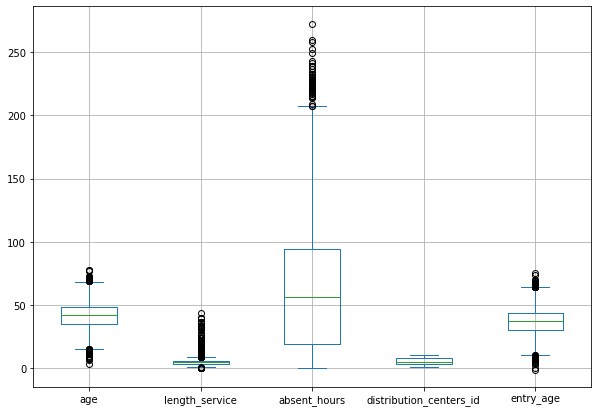

In [ ]:
#Mengecek outlier tiap kolom menggunakan boxplot
df_emp.plot(kind="box", figsize=(10, 7))
plt.grid()
plt.show()

**How to Handling Outlier?** 

**Entry Age**

Berdasarakan referensi dari https://www.quora.com/What-is-the-maximum-age-you-are-allowed-to-work-in-the-USA

Berdasarakan referensi dari https://en.wikipedia.org/wiki/Legal_working_age dan https://www.dol.gov/general/topic/youthlabor/agerequirements

> Tidak ada maximum usia kerja di US

> Min usia kerja di US adalah 16 tahun

**Age**

> Age bergantung berdasarkan entry_age. jadi jika entry_age sudah dihandle, maka age juga ikut terhandle

**Absent_Hours**
> Definisi absen merupakan tidak hadir tanpa alasan? Outlier tidak dibuang karena
rentangnya masih masih memungkinkan (masuk
akal)

**Length_Service**

1 tahun = 12 bulan. 

1 bulan = berapa koma? 1/12? = 0.083

1 tahun = 12/12 = 1

> Outlier tidak dibuang karena sifatnya mengikuti age dan entry_age.

> Max length_service = 43 tahun


#####**Handling Outlier by Fact** 

Outlier yang dihapus berdasarkan fakta yaitu dibuang umur masuk karyawan < 16 tahun

In [ ]:
#copy dataset employee agar dataset asli tidak terganggu
df_emp_clean = df_emp.copy()
df_emp_clean.head()

first_name last_name gender        age  length_service  absent_hours  \
0  Gutierrez     Molly      F  32.028816        6.018478     36.577305   
1   Hardwick   Stephen      M  40.320900        5.532445     30.165071   
2    Delgado   Chester      M  48.822050        4.389973     83.807800   
3      Simon     Irene      F  44.599358        3.081736     70.020164   
4   Delvalle    Edward      M  35.697876        3.619092      0.000000   

   distribution_centers_id  entry_age              nama  
0                        5  26.010338   Gutierrez Molly  
1                        9  34.788456  Hardwick Stephen  
2                       10  44.432076   Delgado Chester  
3                        2  41.517620       Simon Irene  
4                        4  32.078785   Delvalle Edward

In [ ]:
#Menggabungkan nama ke tabel employees, dan menghapus first_name, dan last_name
df_emp_clean = df_emp[['nama','entry_age','gender','age','length_service','absent_hours','distribution_centers_id']]

In [ ]:
#Mencari IQR, max, min dari tiap data numeric
for data in df_emp_clean.select_dtypes(include="number").columns:
  data_iqr = df_emp_clean[data]
  Q1 = data_iqr.quantile(q=.25)
  Q3 = data_iqr.quantile(q=.75)
  IQR = Q3-Q1
  data_atas= Q3+1.5*IQR
  data_bawah = Q1-1.5*IQR
  print('data_bawah', data, data_bawah)
  print('data atas', data, data_atas)

data_bawah entry_age 10.056404625000003
data atas entry_age 64.276045625
data_bawah age 15.246450374999998
data atas age 68.719241375
data_bawah length_service 0.5038468749999994
data atas length_service 8.695967075
data_bawah absent_hours -93.60806775
data atas absent_hours 207.02035025
data_bawah distribution_centers_id -4.5
data atas distribution_centers_id 15.5


In [ ]:
df_emp_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   nama                     8336 non-null   object 
 1   entry_age                8336 non-null   float64
 2   gender                   8336 non-null   object 
 3   age                      8336 non-null   float64
 4   length_service           8336 non-null   float64
 5   absent_hours             8336 non-null   float64
 6   distribution_centers_id  8336 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 456.0+ KB


In [ ]:
#Drop baris age by condition 
df_emp_clean = df_emp_clean.drop(df_emp_clean[(df_emp_clean['entry_age'] < 16)].index)

In [ ]:
#https://linuxhint.com/pandas-remove-rows-condition/#:~:text=To%20delete%20rows%20based%20on%20a%20single%20condition,%5B%20df%20%5B%27release_year%27%5D%20%3C%202012%5D.%20index%2C%20inplace%20%3DFalse%29

#cara akses sampe isi baris dari kolom secara spesifik
#Menghitung jumlah baris berdasaarakan kondisi dibawah
df_emp_clean[(df_emp_clean['entry_age'] < 16)].count()

nama                       0
entry_age                  0
gender                     0
age                        0
length_service             0
absent_hours               0
distribution_centers_id    0
dtype: int64

In [ ]:
#Membandingkan shape sebelum cleaning dan sesudah cleaning
print("Shape awal :", df_emp.shape)
print("Shape akhir :",  df_emp_clean.shape)

Shape awal : (8336, 9)
Shape akhir : (8192, 7)


In [ ]:
df_emp_clean.reset_index(drop = True)

nama  entry_age gender        age  length_service  \
0      Gutierrez Molly  26.010338      F  32.028816        6.018478   
1     Hardwick Stephen  34.788456      M  40.320900        5.532445   
2      Delgado Chester  44.432076      M  48.822050        4.389973   
3          Simon Irene  41.517620      F  44.599358        3.081736   
4      Delvalle Edward  32.078785      M  35.697876        3.619092   
...                ...        ...    ...        ...             ...   
8187   Coniglio Bianca  41.219257      F  46.057545        4.838288   
8188        Cox Jimmie  32.028217      M  34.455490        2.427274   
8189      Hawkins Mary  54.337770      F  58.347160        4.009393   
8190   Proctor Theresa  37.185776      F  43.340614        6.154837   
8191    Salter Charles  41.018063      M  46.192783        5.174722   

      absent_hours  distribution_centers_id  
0        36.577305                        5  
1        30.165071                        9  
2        83.807800                       10  
3        70.020164                        2  
4         0.000000                        4  
...            ...                      ...  
8187     93.665110                        9  
8188      0.000000                        1  
8189    176.356930                        9  
8190     60.321920                        7  
8191    112.023390                        2  

[8192 rows x 7 columns]

In [ ]:
df_emp_outlier = df_emp_clean.copy()
df_emp_no_out = df_emp_clean.copy()

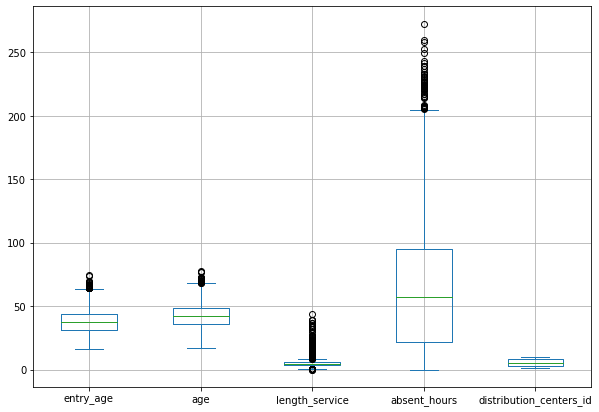

In [ ]:
#Hasil boxplot dari data df_emp_outlier dan hanya di buang age < 16 tahun
df_emp_outlier.plot(kind="box", figsize=(10, 7))
plt.grid()
plt.show()

Terlihat bahwa outlier yang terhapus hanya age < 16 tahun saja. 

#####Handling Outlier All

Membuang outlier dari semua kolom, dengan tujuan untuk melihat apakah **pemodelan** yang dihasilkan lebih baik atau sebaliknya. Kemudian pemodelan tersebut dibandingkan dengan data yang hanya **dibuang age < 16 tahun**

In [ ]:
conditions = [
           (df_emp_clean['absent_hours'] > 207) | (df_emp_clean['length_service'] > 8.7) | (df_emp_clean['age'] > 68.72),
]
result = ['Yes']
df_emp_clean['is_outlier'] = np.select(conditions, result)
df_emp_clean.head()

nama  entry_age gender        age  length_service  \
0   Gutierrez Molly  26.010338      F  32.028816        6.018478   
1  Hardwick Stephen  34.788456      M  40.320900        5.532445   
2   Delgado Chester  44.432076      M  48.822050        4.389973   
3       Simon Irene  41.517620      F  44.599358        3.081736   
4   Delvalle Edward  32.078785      M  35.697876        3.619092   

   absent_hours  distribution_centers_id is_outlier  
0     36.577305                        5          0  
1     30.165071                        9          0  
2     83.807800                       10          0  
3     70.020164                        2          0  
4      0.000000                        4          0

In [ ]:
df_emp_clean['is_outlier'] = df_emp_clean['is_outlier'].apply(lambda x: 'No' if x == '0' else 'Yes')

In [ ]:
df_emp_clean.head()

nama  entry_age gender        age  length_service  \
0   Gutierrez Molly  26.010338      F  32.028816        6.018478   
1  Hardwick Stephen  34.788456      M  40.320900        5.532445   
2   Delgado Chester  44.432076      M  48.822050        4.389973   
3       Simon Irene  41.517620      F  44.599358        3.081736   
4   Delvalle Edward  32.078785      M  35.697876        3.619092   

   absent_hours  distribution_centers_id is_outlier  
0     36.577305                        5         No  
1     30.165071                        9         No  
2     83.807800                       10         No  
3     70.020164                        2         No  
4      0.000000                        4         No

In [ ]:
df_emp_clean.describe().T

count       mean        std        min        25%  \
entry_age                8192.0  37.666038   9.621393  16.067291  30.834451   
age                      8192.0  42.444303   9.447760  17.385454  35.656837   
length_service           8192.0   4.778265   2.475509   0.012098   3.567031   
absent_hours             8192.0  62.360389  48.784730   0.000000  21.843194   
distribution_centers_id  8192.0   5.492920   2.872703   1.000000   3.000000   

                               50%        75%         max  
entry_age                37.577165  44.070357   74.881160  
age                      42.340231  48.775013   77.938000  
length_service            4.592878   5.615217   43.735237  
absent_hours             57.196162  95.000923  272.530120  
distribution_centers_id   5.500000   8.000000   10.000000

In [ ]:
#Drop baris age by condition 
df_emp_no_out = df_emp_no_out.drop(df_emp_no_out[(df_emp_no_out['entry_age'] < 16) | (df_emp_no_out['absent_hours'] > 207.1) | (df_emp_no_out['length_service'] > 8.7) | (df_emp_no_out['age'] > 68.8)].index)

In [ ]:
#Cek jumlah yang telah dihapus tadi
df_emp_no_out[(df_emp_no_out['entry_age'] < 16) | (df_emp_no_out['absent_hours'] > 207.1) | (df_emp_no_out['length_service'] > 8.7) | (df_emp_no_out['age'] > 68.8)].count()

nama                       0
entry_age                  0
gender                     0
age                        0
length_service             0
absent_hours               0
distribution_centers_id    0
dtype: int64

In [ ]:
#Membandingkan shape sebelum cleaning dan sesudah cleaning
print("Shape awal :", df_emp_outlier.shape)
print("Shape akhir :",  df_emp_no_out.shape)

Shape awal : (8192, 7)
Shape akhir : (7991, 7)


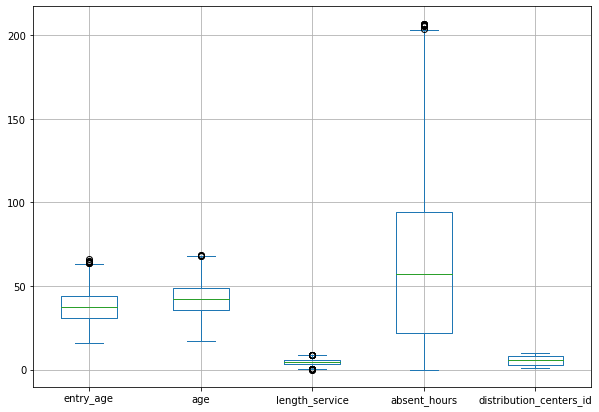

In [ ]:
#Hasil boxplot dari data df_emp_no_out setelah di drop(cleaning)
df_emp_no_out.plot(kind="box", figsize=(10, 7))
plt.grid()
plt.show()

Masih terlihat sedikit outlier sisa, dibiarkan saja karena tidak menganggu

In [ ]:
df_emp_no_out.describe().T

count       mean        std        min        25%  \
entry_age                7991.0  37.646475   9.331590  16.067291  30.974387   
age                      7991.0  42.199107   9.233718  17.385454  35.566389   
length_service           7991.0   4.552632   1.476595   0.012098   3.547662   
absent_hours             7991.0  61.595397  47.212756   0.000000  21.856690   
distribution_centers_id  7991.0   5.497435   2.870586   1.000000   3.000000   

                               50%        75%         max  
entry_age                37.618664  44.023027   66.000000  
age                      42.178440  48.554030   68.492140  
length_service            4.560586   5.551825    8.674857  
absent_hours             57.079900  94.563549  207.011750  
distribution_centers_id   6.000000   8.000000   10.000000

#####Data Profiling

> Data profiling adalah kegiatan merangkum dataset menggunakan statistik deskriptif. Tujuan dari pembuatan data profiling adalah untuk memiliki pemahaman yang kuat tentang data sehingga dapat mulai menyusun framework analisis  dan memvisualisasikan data.

> Untuk melihat data profiling, harus menginstall library di bawah. Kemudian setelah terinstall, harus di restart runtime terlebih dahulu

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 21.8 MB 147 kB/s
     |████████████████████████████████| 596 kB 7.5 MB/s 
     |████████████████████████████████| 102 kB 50.6 MB/s 
     |████████████████████████████████| 690 kB 44.0 MB/s 
     |████████████████████████████████| 4.7 MB 42.9 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 812 kB 56.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=262599 sha256=d494cb0aceb46e4d42150492f4be1cdb8745423a828b5b3a6a98fcdbefae1a58
  Stored in directory: /tmp/pip-ephem-wheel-cache-o49khkab/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=0625715587b3981d50e23b6bf8a71488107735797c728b005e2b94bef700c805
  Stored in director

In [ ]:
#Melihat data profiling pada data employee
import pandas_profiling

pandas_profiling.ProfileReport(df_emp_clean)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

####2.1.2 Visualization

Visualisasi berdasarkan handling outlier fakta (age)

In [ ]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

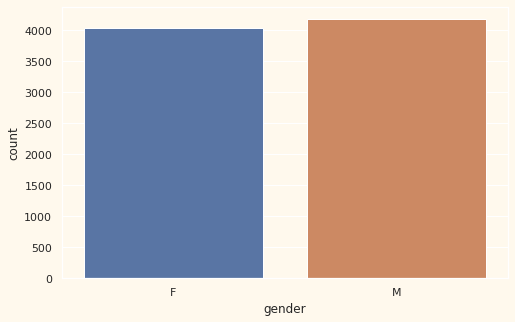

In [ ]:
#Melihat jumlah karyawan berdasarkan gender. Terlihat sedikit lebih banyak laki-laki
plt.figure(figsize=(8,5))
sns.countplot(x="gender", data=df_emp_clean)

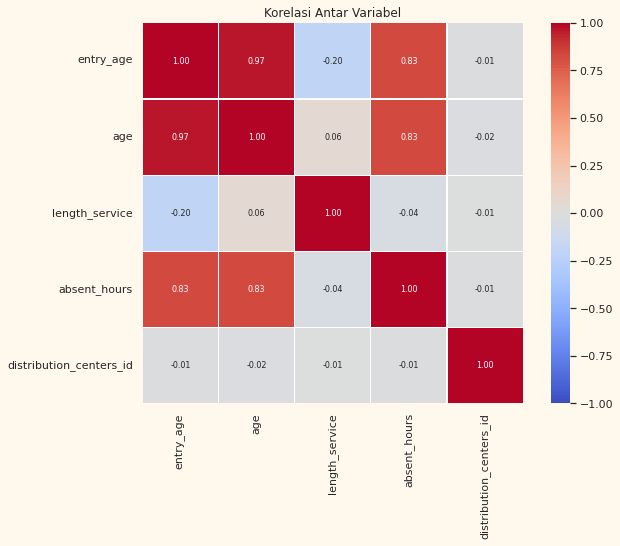

In [ ]:
#https://datagy.io/python-correlation-matrix/
#Lihat korelasi antar variabel
corr = df_emp_clean.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = "coolwarm", annot=True, annot_kws={"size":8}, fmt='.2f', linewidths=0.1, square = True)
plt.title("Korelasi Antar Variabel")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


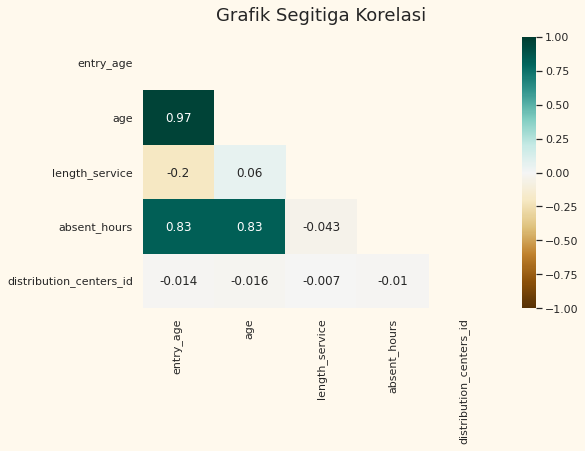

In [ ]:
# Grafik Heatmap 2
plt.figure(figsize=(8, 5))
mask = np.triu(np.ones_like(df_emp_clean.corr(), dtype=np.bool))
heatmap = sns.heatmap(df_emp_clean.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Grafik Segitiga Korelasi', fontdict={'fontsize':18}, pad=16);

###2.2 Distribution centers

In [ ]:
#Mengecek deskriptive dari data distribution centers
df_dc.describe().T

count      mean        std       min        25%       50%  \
id          10.0   5.50000   3.027650    1.0000   3.250000   5.50000   
latitude    10.0  34.67931   4.572666   29.7604  31.024975  33.41665   
longitude   10.0 -87.93855  12.722916 -118.2500 -90.042800 -87.86390   

                75%      max  
id          7.75000  10.0000  
latitude   38.74185  41.8369  
longitude -80.22915 -73.7834

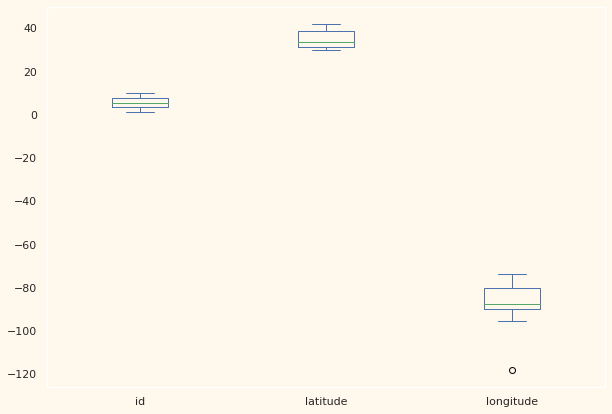

In [ ]:
#Mengecek outlier
df_dc.plot(kind="box", figsize=(10, 7))
plt.grid()
plt.show()

**Insight :**

Tidak adanya outlier berarti tidak perlu handling outlier. Data bisa dibilang aman

####2.2.1 Visualization

In [ ]:
import pandas_profiling

pandas_profiling.ProfileReport(df_dc)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3 Model Development

Kapan menggunakan analisis klaster

> **Exploratory Data Analysis (EDA)** : pengelompokkan data ke dalam klaster-klaster akan memberikan insight terkait objek atau fenomena yang dianalisis

>**Unlabeled data**: ketika data kita tidak memiliki label atau keterangan yang menjadi variabel dependent (Y), maka kita bisa gunakan cluster analysis.

###3.1 Data Preparation

Apakah clustering butuh training dan testing?

https://stats.stackexchange.com/questions/268934/do-we-need-to-set-training-set-and-testing-set-for-clustering

https://stackoverflow.com/questions/13394478/why-we-need-training-and-test-datasets-in-research

Dari penjelasan artikel, tidak butuh train n testing

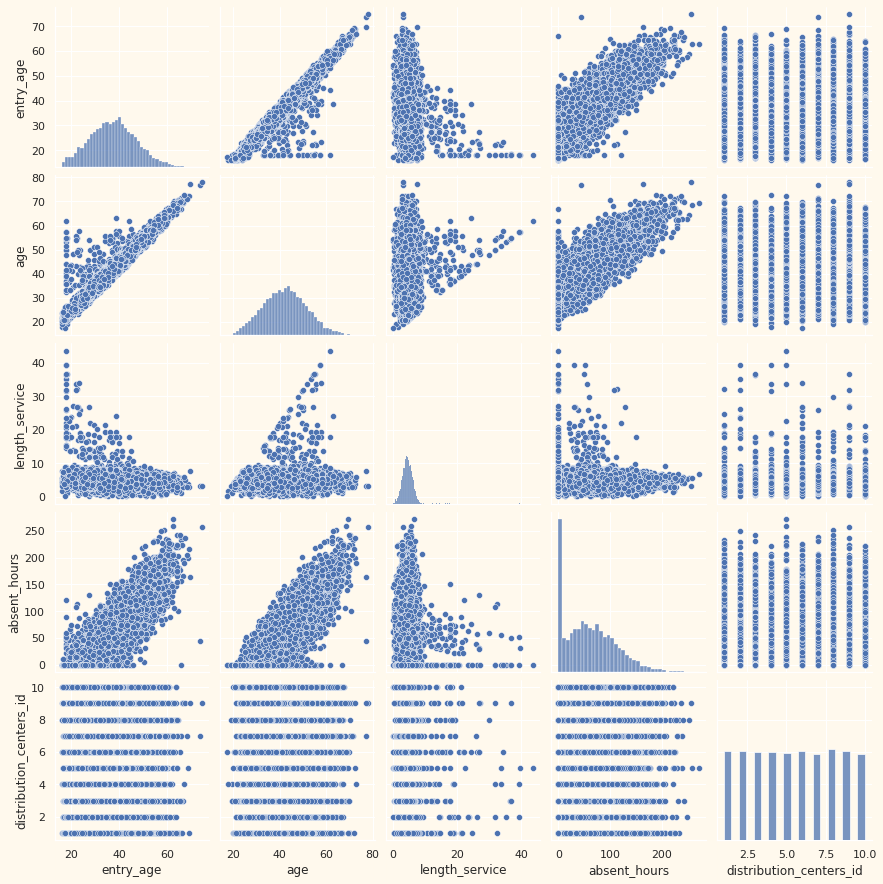

In [ ]:
#Melihat pola 2 hubungan di setiap variabel di data df_emp_outlier
sns.pairplot(df_emp_outlier)

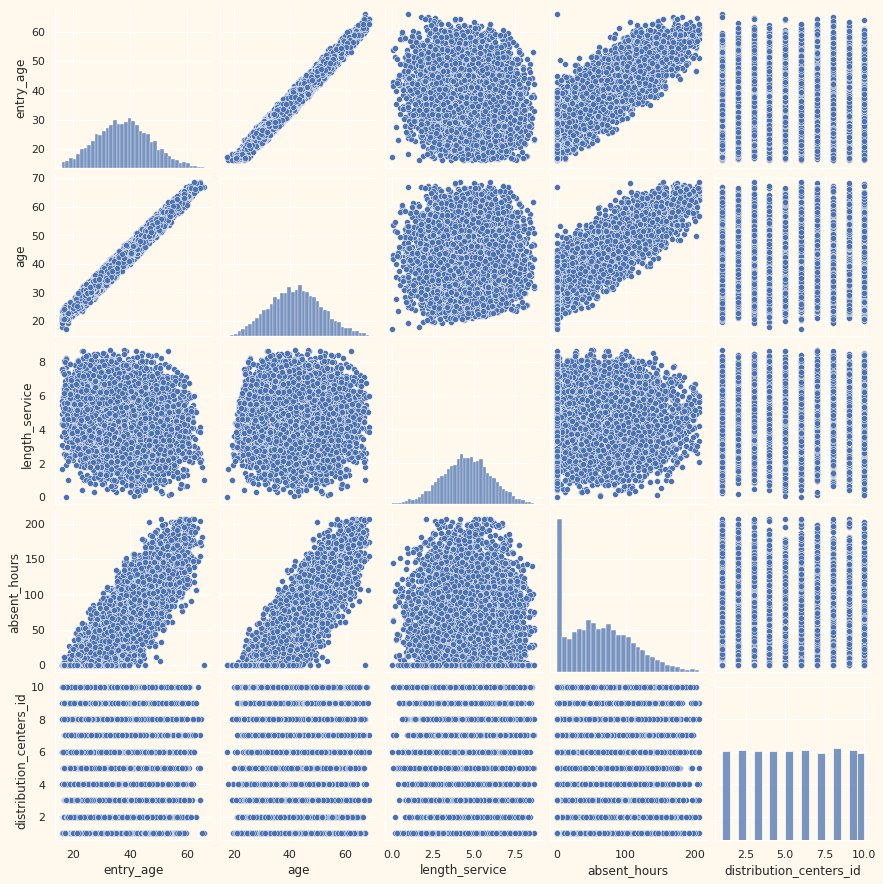

In [ ]:
sns.pairplot(df_emp_no_out)

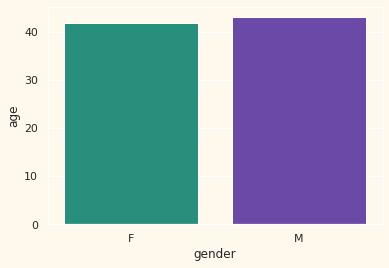

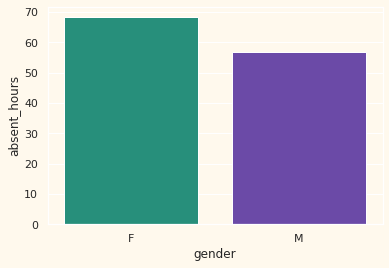

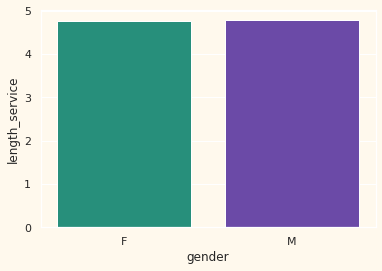

In [ ]:
#Visualisasi berdasarkan data outlier
for data in df_emp_outlier[['age','absent_hours','length_service']]:
  plt.figure(figsize=(6,4))
  temp=df_emp_clean.groupby('gender')[data].mean().reset_index()
  pl = sns.barplot(data=temp,x='gender',y=data, palette=['#16A085','#673AB7']);
  plt.show()

**Insight :**

* Gender dengan Age : Perempuan lebih banyak absent dari laki-laki dari rata"

* Gender dengan Absent_hours : Perempuan cukup tinggi dibanding dengan laki-laki

* Gender dengan length_service : Perempuan setara dengan laki-laki

Persiapan data yang akan kita lakukan adalah:
* mengubah fitur kategorik (`Gender`) menjadi matriks labelEncoder
* melakukan standardisasi semua fitur numerik yang sudah terbentuk

In [ ]:
#Mengcopy data yang ada outlier, untuk dijadikan modelling
X = df_emp_outlier.copy()
X = X[['age','gender','length_service','absent_hours','distribution_centers_id']]
X.head()

age gender  length_service  absent_hours  distribution_centers_id
0  32.028816      F        6.018478     36.577305                        5
1  40.320900      M        5.532445     30.165071                        9
2  48.822050      M        4.389973     83.807800                       10
3  44.599358      F        3.081736     70.020164                        2
4  35.697876      M        3.619092      0.000000                        4

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8192 entries, 0 to 8335
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      8192 non-null   float64
 1   gender                   8192 non-null   object 
 2   length_service           8192 non-null   float64
 3   absent_hours             8192 non-null   float64
 4   distribution_centers_id  8192 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 642.0+ KB


In [ ]:
#Mengcopy data yang tidak ada outlier, untuk dijadikan modelling
X2 = df_emp_no_out.copy()
X2 = X2[['age','gender','length_service','absent_hours','distribution_centers_id']]
X2.head()

age gender  length_service  absent_hours  distribution_centers_id
0  32.028816      F        6.018478     36.577305                        5
1  40.320900      M        5.532445     30.165071                        9
2  48.822050      M        4.389973     83.807800                       10
3  44.599358      F        3.081736     70.020164                        2
4  35.697876      M        3.619092      0.000000                        4

In [ ]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7991 entries, 0 to 8335
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      7991 non-null   float64
 1   gender                   7991 non-null   object 
 2   length_service           7991 non-null   float64
 3   absent_hours             7991 non-null   float64
 4   distribution_centers_id  7991 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 374.6+ KB


#####3.2.1 Encoding categorical (Label Encoder)

Gender merupakan nominal kategorik karena tidak berurutan

ordinal kategorik = kategori yg berurutan

Mengubah fitur kategorik (gender) menjadi labelEncoder

In [ ]:
#Encoding data yang ada outlier
enc = LabelEncoder()
X['gender'] = enc.fit_transform(X['gender'].values)
X.head()

age  gender  length_service  absent_hours  distribution_centers_id
0  32.028816       0        6.018478     36.577305                        5
1  40.320900       1        5.532445     30.165071                        9
2  48.822050       1        4.389973     83.807800                       10
3  44.599358       0        3.081736     70.020164                        2
4  35.697876       1        3.619092      0.000000                        4

In [ ]:
#Encoding data yang tidak ada outlier
enc = LabelEncoder()
X2['gender'] = enc.fit_transform(X2['gender'].values)
X2.head()

age  gender  length_service  absent_hours  distribution_centers_id
0  32.028816       0        6.018478     36.577305                        5
1  40.320900       1        5.532445     30.165071                        9
2  48.822050       1        4.389973     83.807800                       10
3  44.599358       0        3.081736     70.020164                        2
4  35.697876       1        3.619092      0.000000                        4

#####3.2.2 Rescalling

Melakukan standardisasi semua fitur numerik yang sudah terbentuk

In [ ]:
#Scalling data yang ada outlier
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X),columns=X.columns)
print("Dataframe to be used for further modelling:")
X_scaled.head()

Dataframe to be used for further modelling:


age    gender  length_service  absent_hours  distribution_centers_id
0 -1.102497 -1.017487        0.501024     -0.528540                -0.171598
1 -0.224766  0.982814        0.304675     -0.659987                 1.220904
2  0.675095  0.982814       -0.156863      0.439661                 1.569029
3  0.228116 -1.017487       -0.685367      0.157021                -1.215974
4 -0.714120  0.982814       -0.468285     -1.278355                -0.519723

In [ ]:
#Scalling data yang tidak ada outlier
scaler = StandardScaler()
scaler.fit(X2)
X_scaled_2 = pd.DataFrame(scaler.transform(X2),columns=X2.columns)
print("Dataframe to be used for further modelling:")
X_scaled_2.head()

Dataframe to be used for further modelling:


age    gender  length_service  absent_hours  distribution_centers_id
0 -1.101499 -1.021889        0.992783     -0.529934                -0.173298
1 -0.203420  0.978580        0.663604     -0.665758                 1.220233
2  0.717301  0.978580       -0.110165      0.470504                 1.568616
3  0.259960 -1.021889       -0.996203      0.178454                -1.218446
4 -0.704119  0.978580       -0.632264     -1.304716                -0.521680

####3.2.2 Dimensionality Reduction (PCA)

Dimensionality reduction atau reduksi dimensi adalah teknik untuk mengurangi dimensi dataset dalam hal ini fitur data. Ini bertujuan agar performa algoritma representatif. Menggunakan algoritma PCA (Principal Component Analysis)

How to dimensionlity reduction? PCA?

https://ilmudatapy.com/teknik-reduksi-dimensi/

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

https://machinelearningmastery.com/dimensionality-reduction-algorithms-with-python/

Perbedaan fit, predict, fit_predict

https://towardsdatascience.com/fit-vs-predict-vs-fit-predict-in-python-scikit-learn-f15a34a8d39f#:~:text=fit%20%28%29%20method%20will%20fit%20the%20model%20to,unsupervised%20learning%20where%20we%20don%E2%80%99t%20have%20labelled%20inputs.

In [ ]:
#Initiating PCA to reduce dimentions aka features to 2 untuk data yang ada outlier (df_emp_outlier)
pca = PCA(n_components=2)
pca.fit(X_scaled)
PCA_ds = pd.DataFrame(pca.transform(X_scaled), columns=(["col1","col2"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  8192.0 -1.734723e-18  1.355459 -2.853669 -1.046138 -0.078686  0.909854   
col2  8192.0  3.469447e-18  1.013055 -2.104121 -0.872255  0.085866  0.789167   

           max  
col1  5.496296  
col2  9.189481

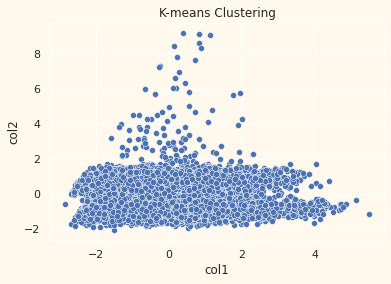

In [ ]:
sns.scatterplot(x="col1", y="col2", data=PCA_ds)
plt.title('K-means Clustering')
plt.show()

> Untuk menentukan cluster yang baik bisa menggunakan algoritma dari KElbowVisualizer

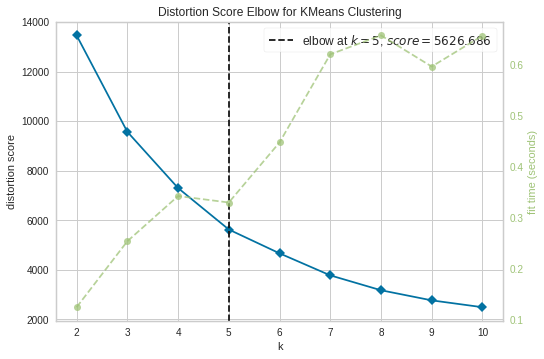

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

**insight** : 

> Dilihat dari algoritma KElbowVisualizer bahwa n cluster yang bagus = 5

> Tetapi, sebagai perbandingan juga dilakukan modelling dengan n cluster = 4

In [ ]:
#Initiating PCA to reduce dimentions aka features to 2 for cluster 5
pca_2 = PCA(n_components=2)
pca_2.fit(X_scaled_2)
PCA_ds_2 = pd.DataFrame(pca_2.transform(X_scaled_2), columns=(["col1","col2"]))
PCA_ds_2.describe().T

count          mean      std       min       25%       50%       75%  \
col1  7991.0 -4.445894e-18  1.35732 -2.889360 -1.057762 -0.066235  0.947845   
col2  7991.0  6.313169e-17  1.01144 -2.259451 -0.897355 -0.028273  0.907205   

           max  
col1  4.208815  
col2  2.387415

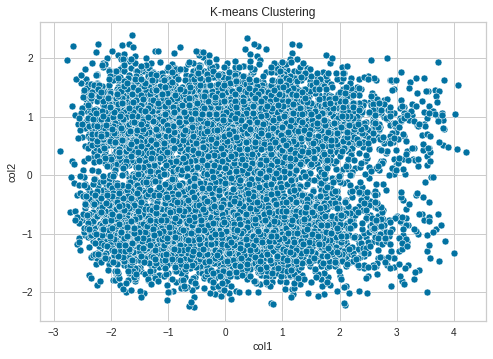

In [ ]:
sns.scatterplot(x="col1", y="col2", data=PCA_ds_2)
plt.title('K-means Clustering')
plt.show()

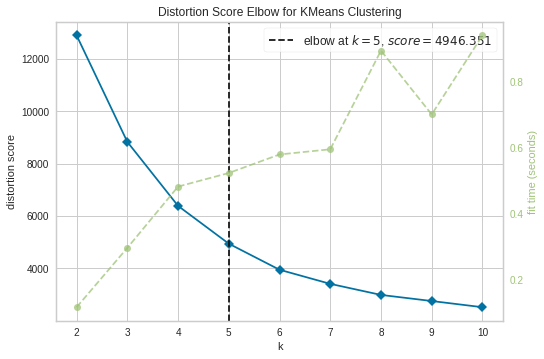

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds_2)
Elbow_M.show()

###3.2 K-Means

Kluster 4

In [ ]:
#Menggunakan kluster 4 untuk data yang ada outlier
K = 4
kmeans = KMeans(n_clusters=K, random_state=11)

start = time()
print(f"Done fitting kMeans in {time()-start:.3f}s")
predict = kmeans.fit_predict(PCA_ds)
PCA_ds['clusters'] =  predict
PCA_ds.head()

Done fitting kMeans in 0.000s


col1      col2  clusters
0 -1.087644 -0.621401         2
1 -0.698397  0.924851         1
2  0.698919  0.662015         0
3  0.340647 -1.122418         3
4 -1.452386  0.569481         1

In [ ]:
#Menggunakan kluster 4 untuk data yang tidak ada outlier
K = 4
kmeans_5 = KMeans(n_clusters=K, random_state=11)

start = time()
print(f"Done fitting kMeans in {time()-start:.3f}s")
predict_2 = kmeans_5.fit_predict(PCA_ds_2)
PCA_ds_2['clusters'] =  predict_2
PCA_ds_2.head()

Done fitting kMeans in 0.000s


col1      col2  clusters
0 -1.106549  0.665162         0
1 -0.661298 -1.487027         3
2  0.774925 -1.329506         1
3  0.353121  1.603370         2
4 -1.444431 -0.482852         3

In [ ]:
#Untuk warna pallete pada saat visualisasi 
pal = ["#682F2F", "#303fdb", "#fc355d","#F3AB60"]
pal_5 = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60", "#303fdb"]

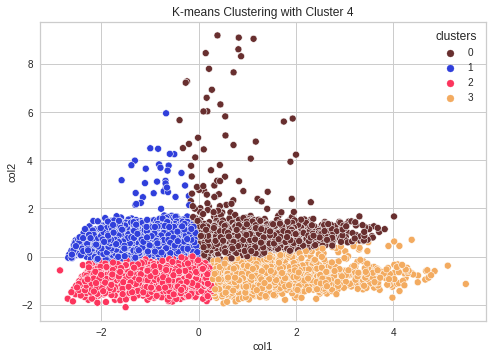

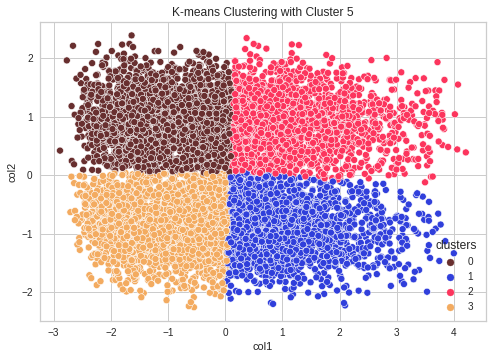

In [ ]:
#Visualisasi yang terbentuk dari cluster = 4
sns.scatterplot(x="col1", y="col2", hue=PCA_ds['clusters'], data=PCA_ds, palette=pal)
plt.title('K-means Clustering with Cluster 4')
plt.show()

#Visualisasi yang terbentuk dari cluster = 5
sns.scatterplot(x="col1", y="col2", hue=PCA_ds_2['clusters'], data=PCA_ds_2, palette=pal)
plt.title('K-means Clustering with Cluster 5')
plt.show()

Kluster 5

In [ ]:
#Menggunakan kluster 4 untuk data yang ada outlier
K = 5
kmeans_5 = KMeans(n_clusters=K, random_state=11)

start = time()
print(f"Done fitting kMeans in {time()-start:.3f}s")
predict = kmeans_5.fit_predict(PCA_ds)
PCA_ds['clusters_5'] =  predict
PCA_ds.head()

Done fitting kMeans in 0.000s


col1      col2  clusters  clusters_5
0 -1.087644 -0.621401         2           1
1 -0.698397  0.924851         1           3
2  0.698919  0.662015         0           0
3  0.340647 -1.122418         3           2
4 -1.452386  0.569481         1           3

In [ ]:
#Menggunakan kluster 4 untuk data yang tidak ada outlier
K = 5
kmeans_5 = KMeans(n_clusters=K, random_state=11)

start = time()
print(f"Done fitting kMeans in {time()-start:.3f}s")
predict_2 = kmeans_5.fit_predict(PCA_ds_2)
PCA_ds_2['clusters_5'] =  predict_2
PCA_ds_2.head()

Done fitting kMeans in 0.000s


col1      col2  clusters  clusters_5
0 -1.106549  0.665162         0           0
1 -0.661298 -1.487027         3           2
2  0.774925 -1.329506         1           1
3  0.353121  1.603370         2           4
4 -1.444431 -0.482852         3           2

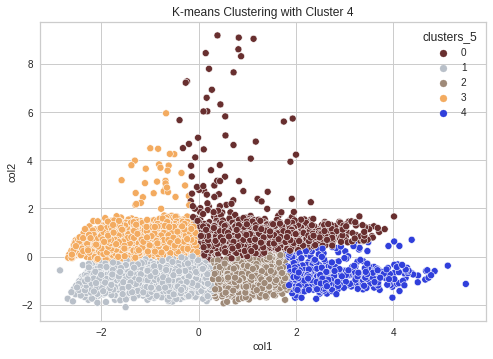

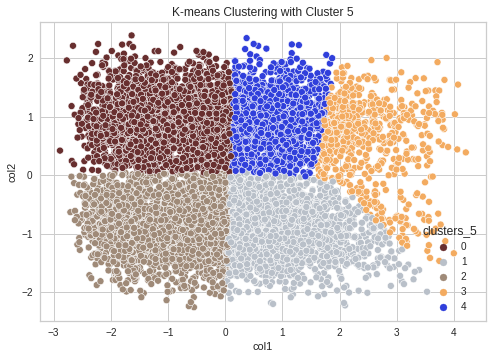

In [ ]:
#Visualisasi yang terbentuk dari cluster = 5
sns.scatterplot(x="col1", y="col2", hue=PCA_ds['clusters_5'], data=PCA_ds, palette=pal_5)
plt.title('K-means Clustering with Cluster 4')
plt.show()

#Visualisasi yang terbentuk dari cluster = 5
sns.scatterplot(x="col1", y="col2", hue=PCA_ds_2['clusters_5'], data=PCA_ds_2, palette=pal_5)
plt.title('K-means Clustering with Cluster 5')
plt.show()

**Insight :**

* Terlihat bahwa data yang tidak memiliki outlier pengelompokkan cluster bagus, 
* sedangkan data yang memiliki outlier masih agak menyebar, tapi sudah cukup bagus

In [ ]:
PCA_ds.to_csv (r'/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/PCA_outlier.csv', index = False, header=True)

In [ ]:
PCA_ds_2.to_csv (r'/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/PCA_no_outlier.csv', index = False, header=True)

###3.3 Model Evaluation

####3.3.1 Cluster Cardinality

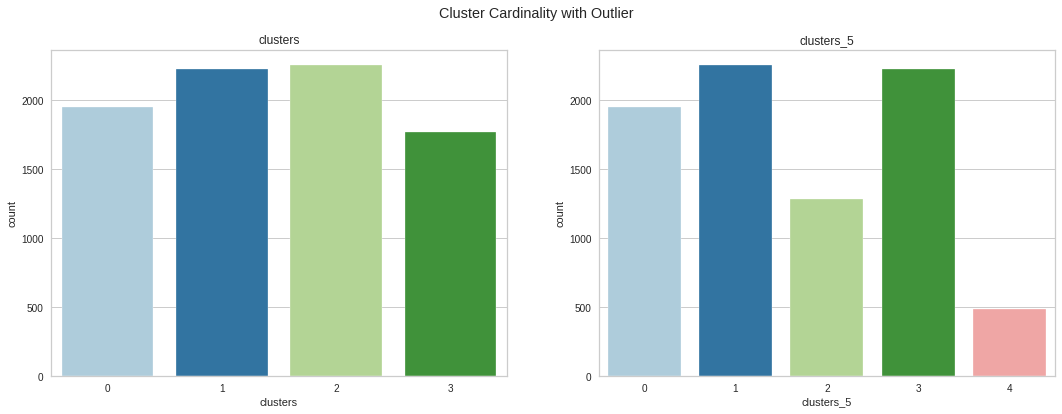

In [ ]:
#Data yang ada outlier
fig, axis = plt.subplots(1, 2, figsize=(18, 6))
for ax, preds in zip(axis, ["clusters", "clusters_5"]):
    sns.countplot(x=preds, data=PCA_ds, ax=ax, palette="Paired")
    ax.set_title(preds)
plt.suptitle("Cluster Cardinality with Outlier")
plt.show()

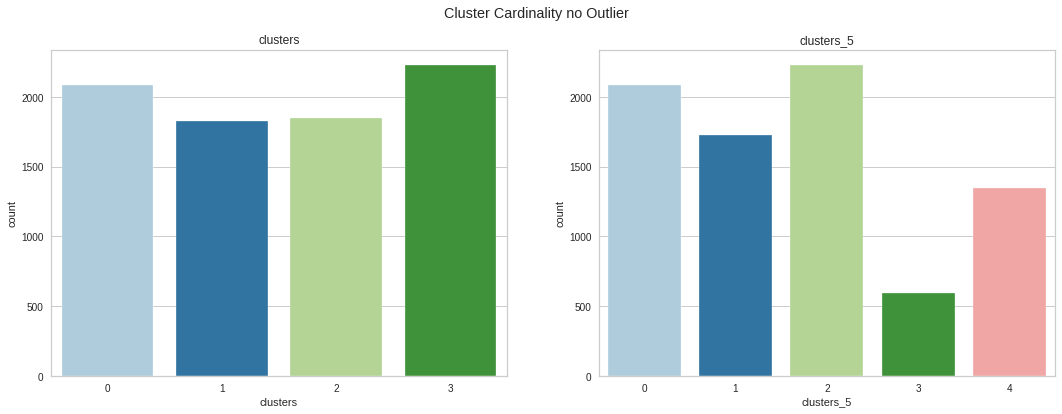

In [ ]:
#Data yang tidak ada outlier
fig, axis = plt.subplots(1, 2, figsize=(18, 6))
for ax, preds in zip(axis, ["clusters", "clusters_5"]):
    sns.countplot(x=preds, data=PCA_ds_2, ax=ax, palette="Paired")
    ax.set_title(preds)
plt.suptitle("Cluster Cardinality no Outlier")
plt.show()

**Insight :**

`Data yang ada outlier`

---

Dari visualisasi _cluster cardinality_ di atas:
* Model dengan 4 cluster (k=4), terlihat bahwa tidak terdapat perbedaan cukup jauh antara cluster 0 sampai 3
* Model dengan 5 cluster (k=5), terlihat kardinalitas cluster `4` cukup jauh lebih dibandingkan dengan cluster yang lain.

`Data yang tidak ada outlier`

---

* Model dengan 4 cluster (k=4), terlihat bahwa tidak terdapat perbedaan cukup jauh antara cluster 0 sampai 3
* Model dengan 5 cluster (k=5), terlihat kardinalitas cluster `3` cukup jauh lebih dibandingkan dengan cluster yang lain.

####3.3.2 Silhoutte Score

Silhoutte score adalah ukuran seberapa mirip suatu objek dengan clusternya sendiri dibandingkan dengan cluster lain digunakan untuk mengukur akurasi dari pemodelan. Memiliki rentang -1 sampai 1

In [ ]:
# This gives a perspective into the density and separation of the formed
# Silhoutte score from data outlier
from sklearn.metrics import silhouette_samples, silhouette_score

clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(PCA_ds)
silhouette_avg = silhouette_score(PCA_ds, cluster_labels)
print("silhouette_score from cluster 4 :\n", silhouette_avg)

clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(PCA_ds)
silhouette_avg = silhouette_score(PCA_ds, cluster_labels)
print("silhouette_score from cluster 5 :\n", silhouette_avg)

silhouette_score from cluster 4 :
 0.6222254288379521
silhouette_score from cluster 5 :
 0.6443286923696205


In [ ]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# Silhoutte score 
from sklearn.metrics import silhouette_samples, silhouette_score

clusterer1 = KMeans(n_clusters=4, random_state=10)
cluster_labels1 = clusterer1.fit_predict(PCA_ds_2)
silhouette_avg1 = silhouette_score(PCA_ds_2, cluster_labels1)
print("silhouette_score from cluster 4 :\n", silhouette_avg1)

clusterer1 = KMeans(n_clusters=5, random_state=10)
cluster_labels1 = clusterer1.fit_predict(PCA_ds_2)
silhouette_avg1 = silhouette_score(PCA_ds_2, cluster_labels1)
print("silhouette_score from cluster 5 :\n", silhouette_avg1)

silhouette_score from cluster 4 :
 0.6431044389982707
silhouette_score from cluster 5 :
 0.636266088443639


**Insight**

`Data yang ada outlier`

---

* Silhoutte score dari cluster 4 = 0.622
* Silhoutte score dari cluster 5 = 0.644
* Bisa disimpulkan, bahwa perbedaan dari ke 2 score cluster tidak cukup jauh

`Data yang ada tidak ada outlier`

---

* Silhoutte score dari cluster 4 = 0.643
* Silhoutte score dari cluster 5 = 0.636
* Bisa disimpulkan, bahwa perbedaan dari ke 2 score cluster tidak cukup jauh, dan cluster 4 sedikit lebih tinggi scorenya

Diputuskan yang akan digunakan yaitu **cluster 4** karena score nya lebih tinggi, cluster cardinality juga bagus, selain itu agar lebih mudah interpretasi di sisi HR


####3.3.3 Evaluasi Pemodelan

In [ ]:
hasil = df_emp_outlier.copy().reset_index(drop = True)
hasil['cluster'] = PCA_ds['clusters']
hasil.head()

nama  entry_age gender        age  length_service  \
0   Gutierrez Molly  26.010338      F  32.028816        6.018478   
1  Hardwick Stephen  34.788456      M  40.320900        5.532445   
2   Delgado Chester  44.432076      M  48.822050        4.389973   
3       Simon Irene  41.517620      F  44.599358        3.081736   
4   Delvalle Edward  32.078785      M  35.697876        3.619092   

   absent_hours  distribution_centers_id  cluster  
0     36.577305                        5        2  
1     30.165071                        9        1  
2     83.807800                       10        0  
3     70.020164                        2        3  
4      0.000000                        4        1

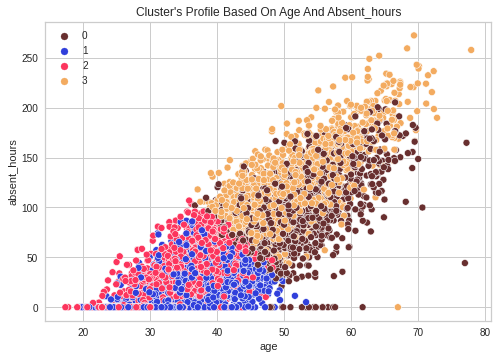

In [ ]:
#Melihat pola cluster pada variable age dan absent_hours
pl = sns.scatterplot(data =hasil ,x=hasil["age"], y=hasil["absent_hours"],hue=hasil["cluster"], palette= pal)
pl.set_title("Cluster's Profile Based On Age And Absent_hours")
plt.legend()
plt.show()

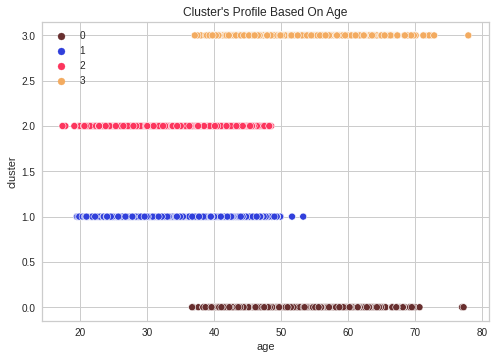

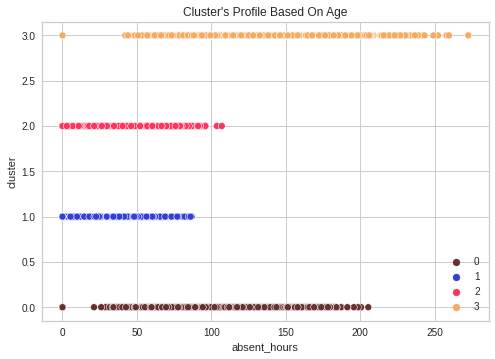

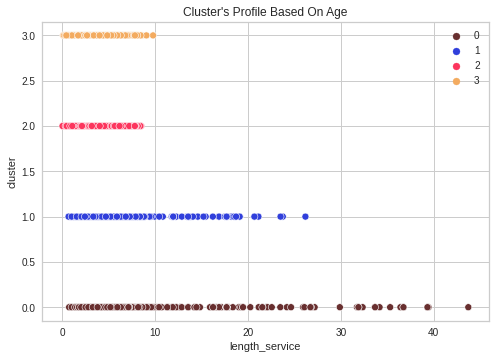

In [ ]:
#Melihat pengelompokkan kolom age, absent_hours dan length_service berdasarkan cluster
for data in hasil[['age','absent_hours','length_service']]:
  pl = sns.scatterplot(data =hasil ,x=hasil[data], y=hasil["cluster"], hue=hasil['cluster'], palette= pal)
  pl.set_title("Cluster's Profile Based On Age")
  plt.legend()
  plt.show()

In [ ]:
hasil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      8192 non-null   float64
 1   gender                   8192 non-null   int64  
 2   length_service           8192 non-null   float64
 3   absent_hours             8192 non-null   float64
 4   distribution_centers_id  8192 non-null   int64  
 5   cluster                  8192 non-null   int32  
dtypes: float64(3), int32(1), int64(2)
memory usage: 352.1 KB


In [ ]:
hasil.describe().T

count       mean        std        min        25%  \
age                      8192.0  42.444303   9.447760  17.385454  35.656837   
gender                   8192.0   0.508667   0.499955   0.000000   0.000000   
length_service           8192.0   4.778265   2.475509   0.012098   3.567031   
absent_hours             8192.0  62.360389  48.784730   0.000000  21.843194   
distribution_centers_id  8192.0   5.492920   2.872703   1.000000   3.000000   
cluster                  8192.0   1.468506   1.075463   0.000000   1.000000   

                               50%        75%         max  
age                      42.340231  48.775013   77.938000  
gender                    1.000000   1.000000    1.000000  
length_service            4.592878   5.615217   43.735237  
absent_hours             57.196162  95.000923  272.530120  
distribution_centers_id   5.500000   8.000000   10.000000  
cluster                   1.000000   2.000000    3.000000

In [ ]:
#Melihat jumlah, min, max, rata-rata tiap kolom berdasarkan cluster
hasil.groupby('cluster').agg(['count','min','max','mean'])

entry_age                                    age             \
            count        min        max       mean count        min   
cluster                                                               
0            1949  17.999998  73.796150  45.107271  1949  36.718925   
1            2224  16.202896  50.415360  31.374480  2224  19.512960   
2            2251  16.067291  46.022705  30.853936  2251  17.385454   
3            1768  33.059730  74.881160  46.050373  1768  37.121680   

                              length_service                                 \
               max       mean          count       min        max      mean   
cluster                                                                       
0        77.238100  50.491114           1949  0.727527  43.735237  5.383842   
1        53.303036  36.206192           2224  0.665395  26.185802  4.831712   
2        48.522316  35.309036           2251  0.012098   8.484806  4.455100   
3        77.938000  50.505283           1768  0.085149   9.768702  4.454910   

        absent_hours                              distribution_centers_id      \
               count  min         max        mean                   count min   
cluster                                                                         
0               1949  0.0  205.348820   92.510193                    1949   1   
1               2224  0.0   86.752430   22.960276                    2224   1   
2               2251  0.0  106.967094   32.593139                    2251   1   
3               1768  0.0  272.530120  116.585482                    1768   1   

                       
        max      mean  
cluster                
0        10  5.320164  
1        10  5.608813  
2        10  5.548645  
3        10  5.466629

**Insight :**

Berdasarkan analisa menggunakan fungsi aggregat function (count, min, max, absent_hours) bisa disimpulkan  :

* Cluster 0 : **Low** produktivitas karena rata-rata absent_hours tinggi, dan juga age yang sudah memasuki usia tua. Kemudian, lama jabatannya pun juga cukup tinggi
* cluster 1 : **'High'** produktivitas karena Age dengan usia muda kemudian absent_hours dengan rata-rata paling sedikit dibandingkan cluster lainnya yaitu selama 23 jam. Kemudian, untuk lama jabatan tidak terlalu lama, kemungkinan karena masih dengan usia muda
* Cluster 2 : **Middle** produktivitas karena Age tetap masih usia muda tetapi absent_hours nya sedikit lebih tinggi daripada cluster 1
* Cluster 3 : **Very Low** karena Age dengan usia rata-rata memasuki usia tua, kemudian absent_hours dengan rata-rata dan maximum paling tinggi dibandingkan cluster lainnya

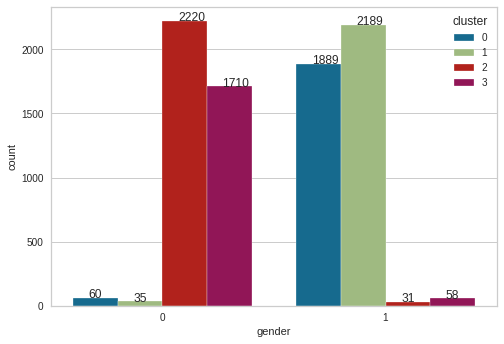

In [ ]:
#Melihat jumlah gender berdasarkan tiap cluster
ax = sns.countplot(x =hasil['gender'], data =hasil,hue = "cluster")
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.07, p.get_height()+0.05))
plt.show()

**Hasil No Outlier**

In [ ]:
hasil_no_out = df_emp_no_out.copy().reset_index(drop = True)
hasil_no_out['cluster'] = PCA_ds_2['clusters']
hasil_no_out.head()

nama  entry_age gender        age  length_service  \
0   Gutierrez Molly  26.010338      F  32.028816        6.018478   
1  Hardwick Stephen  34.788456      M  40.320900        5.532445   
2   Delgado Chester  44.432076      M  48.822050        4.389973   
3       Simon Irene  41.517620      F  44.599358        3.081736   
4   Delvalle Edward  32.078785      M  35.697876        3.619092   

   absent_hours  distribution_centers_id is_outlier  cluster  
0     36.577305                        5         No        0  
1     30.165071                        9         No        3  
2     83.807800                       10         No        1  
3     70.020164                        2         No        2  
4      0.000000                        4         No        3

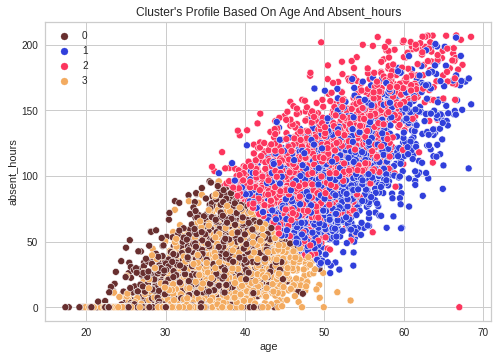

In [ ]:
#Melihat pola cluster pada variable age dan absent_hours
pl = sns.scatterplot(data =hasil_no_out ,x=hasil_no_out["age"], y=hasil_no_out["absent_hours"],hue=hasil_no_out["cluster"], palette= pal)
pl.set_title("Cluster's Profile Based On Age And Absent_hours")
plt.legend()
plt.show()

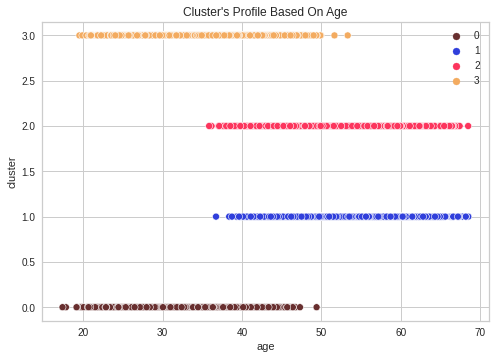

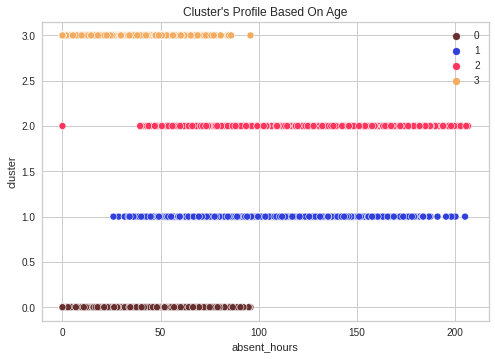

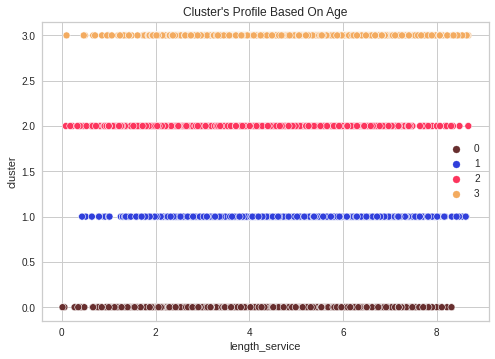

In [ ]:
#Melihat pengelompokkan kolom age, absent_hours dan length_service berdasarkan cluster
for data in hasil_no_out[['age','absent_hours','length_service']]:
  pl = sns.scatterplot(data =hasil_no_out ,x=hasil_no_out[data], y=hasil_no_out["cluster"], hue=hasil_no_out['cluster'], palette= pal)
  pl.set_title("Cluster's Profile Based On Age")
  plt.legend()
  plt.show()

####3.3.4 Pelabelan Cluster

Dilakukan labeling untuk mengetahui tingkat produktivitas karyawan dari yang very low - high level. Disini labelin menggunakan data yang memiliki outlier, karena akan direpsentasikan ke tableau. Kemudian karena di tableau lebih interaktif, jadi bisa di dihapus outlier atau pun tetap di masukkan

In [ ]:
def cluster_label (cluster):
  if cluster == 0:
    cluster_name = 'Low'
  elif cluster == 1:
    cluster_name = 'High'
  elif cluster == 2:
    cluster_name = 'Middle'
  else:
    cluster_name = 'Very Low'
  return cluster_name

In [ ]:
hasil['cluster_label'] = hasil['cluster'].apply(lambda x: cluster_label(x))

In [ ]:
hasil.head()

nama  entry_age gender        age  length_service  \
0   Gutierrez Molly  26.010338      F  32.028816        6.018478   
1  Hardwick Stephen  34.788456      M  40.320900        5.532445   
2   Delgado Chester  44.432076      M  48.822050        4.389973   
3       Simon Irene  41.517620      F  44.599358        3.081736   
4   Delvalle Edward  32.078785      M  35.697876        3.619092   

   absent_hours  distribution_centers_id is_outlier  cluster cluster_label  
0     36.577305                        5         No        2        Middle  
1     30.165071                        9         No        1          High  
2     83.807800                       10         No        0           Low  
3     70.020164                        2         No        3      Very Low  
4      0.000000                        4         No        1          High

In [ ]:
hasil.to_csv (r'/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/result_HR.csv', index = False, header=True)

**Insight:**

Modelling tanpa outlier terlihat lebih bagus daripada outlier, meskipun begitu ada beberapa yang kurang jika menggunakan modelling tanpa outlier:

* Jika dilihat berdasarkan fakta, kita menggunakan adanya outlier. 
* jika kita ingin mencari karyawan yang loyal + produktif, maka menggunakan modelling outlier. Why? karena jika menggunakan modelling tanpa outlier, karyawan dengan kriteria tersebut bisa saja terbuang ketika di cleaning, dan itu tidak relevan apabila kita ingin memberika reward kepada karyawan tersebut
* Modelling tanpa outlier menghasilkan pelabelan yang lebih akurat tetapi banyak data yang terbuang, sedangkan modelling dengan outlier kurang akurat dan merepresentatif seluruh data
* Age dan lama jabatan tidak berhubungan.


**Insight yang bisa dihasilkan untuk bisnis:**

* Membatasi absensi (dengan peraturan tertentu) agar lebih produktif
* Untuk karyawan produktivitas 'Low' maupun 'Very low'. Tim HR bisa melihat kembali sebabnya apa, dan membuat kebijakan baru mengenai absent atau yang lainnya.
* Untuk karyawan produktivitas 'Middle'. Tim HR bisa mengadakan training agar lebih meningkatkan produktivitas karyawan, dan bisa berpengaruh kepada profit perusahaan
* Untuk distribusi wilayah dengan produktivitas rendah. Tim HR bisa memantau kembali apa yang salah. Jika ternyata karena lingkungan kerja buruk, maka bisa menciptakan lingkungan kerja yang baik dan positif.Mengadakan training
* Age dan absent saling berhubungan. Jika dilihat dari data, umur yang lebih muda lebih produktif dibandingkan umur yang meranjak tua. Tim HR bisa mempertimbangkan usia muda saat merekrut karyawan



##4 Merge Data Employees and Distribution Centers

Menggabungkan data employees yang telah di modelling dengan data distribution centers

In [ ]:
result_join_emp_dc = pd.merge(hasil, df_dc, how="inner", left_on=["distribution_centers_id"], right_on=['id'])
result_join_emp_dc.head()

nama  entry_age gender        age  length_service  absent_hours  \
0  Gutierrez Molly  26.010338      F  32.028816        6.018478     36.577305   
1      Watkins Jan  25.684132      F  36.910410       11.226280     94.668564   
2      Price David  43.300343      M  43.686090        0.385746     38.066586   
3   Shultz Charles  26.048798      M  29.329834        3.281037      0.000000   
4      Mejia James  38.503800      M  42.628407        4.124607     24.792871   

   distribution_centers_id is_outlier  cluster cluster_label  id  \
0                        5         No        2        Middle   5   
1                        5        Yes        0           Low   5   
2                        5         No        2        Middle   5   
3                        5         No        1          High   5   
4                        5         No        1          High   5   

             name  latitude  longitude  
0  New Orleans LA     29.95   -90.0667  
1  New Orleans LA     29.95   -90.0667  
2  New Orleans LA     29.95   -90.0667  
3  New Orleans LA     29.95   -90.0667  
4  New Orleans LA     29.95   -90.0667

In [ ]:
result_join_emp_dc.to_csv (r'/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/result_emp_dc.csv', index = False, header=True)